In [2]:
import pandas as pd
from pathlib import Path

DATA_PATH = Path("../data/processed/monthly_features.csv")
df = pd.read_csv(DATA_PATH, parse_dates=["year_month"])


In [3]:
df = df.sort_values("year_month")

train = df.iloc[:-12].copy()
test = df.iloc[-12:].copy()

features = ["year", "month", "quarter", "is_year_start", "is_year_end", "is_q_start", "is_q_end", "lag_1", "rolling_mean_3", "rolling_std_3"]
target = "permit_count"


In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

model = RandomForestRegressor(random_state=42)
model.fit(train[features], train[target])

preds = model.predict(test[features])


In [5]:
from math import sqrt

mae = mean_absolute_error(test[target], preds)
rmse = sqrt(mean_squared_error(test[target], preds))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 10.75
RMSE: 14.74


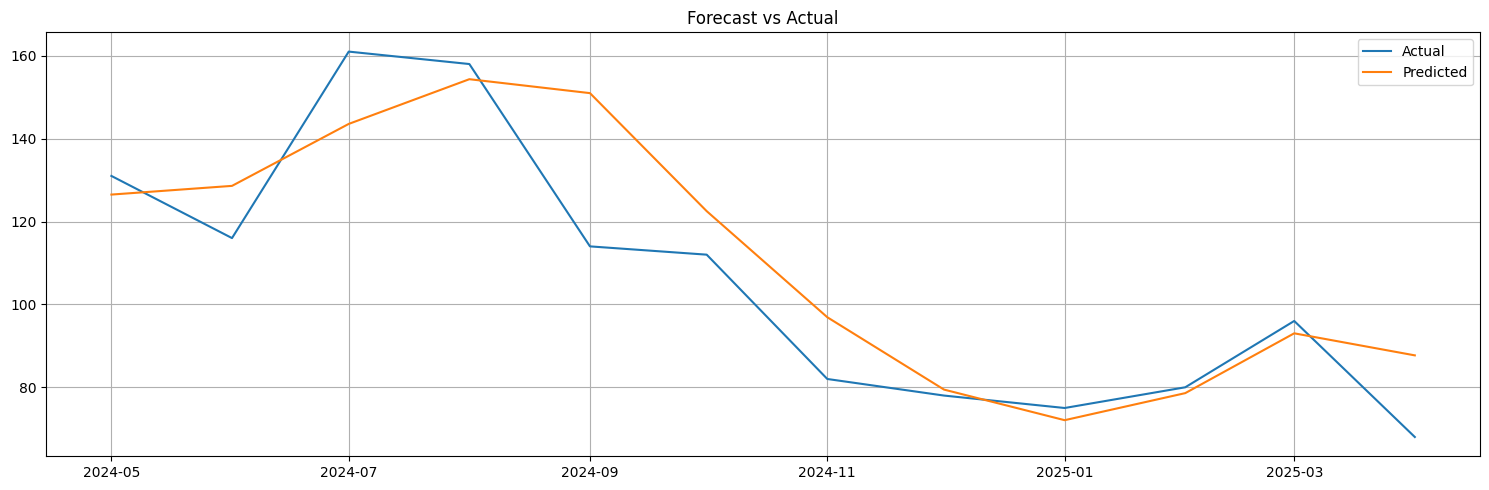

In [6]:
import matplotlib.pyplot as plt

test = test.copy()
test["prediction"] = preds

plt.figure(figsize=(15, 5))
plt.plot(test["year_month"], test["permit_count"], label="Actual")
plt.plot(test["year_month"], test["prediction"], label="Predicted")
plt.legend()
plt.title("Forecast vs Actual")
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(train[features], train[target])
xgb_preds = xgb_model.predict(test[features])


In [8]:
mae_xgb = mean_absolute_error(test[target], xgb_preds)
rmse_xgb = sqrt(mean_squared_error(test[target], xgb_preds))

print(f"[XGBoost] MAE: {mae_xgb:.2f} | RMSE: {rmse_xgb:.2f}")


[XGBoost] MAE: 11.93 | RMSE: 15.51


In [10]:
pip install prophet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 10.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 903.1/903.1 kB 8.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [11]:
from prophet import Prophet

df_prophet = df[["year_month", "permit_count"]].rename(columns={"year_month": "ds", "permit_count": "y"})
train_prophet = df_prophet.iloc[:-12]
test_prophet = df_prophet.iloc[-12:]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [12]:
prophet_model = Prophet()
prophet_model.fit(train_prophet)

future = prophet_model.make_future_dataframe(periods=12, freq="M")
forecast = prophet_model.predict(future)


16:10:52 - cmdstanpy - INFO - Chain [1] start processing
16:10:53 - cmdstanpy - INFO - Chain [1] done processing
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


In [14]:
# Align forecast with test dates
forecast_subset = forecast[["ds", "yhat"]]
merged = test[["year_month", "permit_count"]].merge(forecast_subset, left_on="year_month", right_on="ds", how="left")

prophet_preds = merged["yhat"].values
actuals = merged["permit_count"].values


In [17]:
forecast[["ds"]].tail(20)


,ds
210,2023-09-01
211,2023-10-01
212,2023-11-01
213,2023-12-01
214,2024-01-01
215,2024-02-01
216,2024-03-01
217,2024-04-01
218,2024-04-30
219,2024-05-31


In [18]:
test["year_month"]


218   2024-05-01
219   2024-06-01
220   2024-07-01
221   2024-08-01
222   2024-09-01
223   2024-10-01
224   2024-11-01
225   2024-12-01
226   2025-01-01
227   2025-02-01
228   2025-03-01
229   2025-04-01
Name: year_month, dtype: datetime64[ns]

In [19]:
forecast["ds"] = forecast["ds"].dt.to_period("M").dt.to_timestamp()
test["year_month"] = test["year_month"].dt.to_period("M").dt.to_timestamp()


In [20]:
merged = test[["year_month", "permit_count"]].merge(
    forecast[["ds", "yhat"]],
    left_on="year_month",
    right_on="ds",
    how="left"
)

merged = merged.dropna(subset=["yhat"])


In [21]:
prophet_preds = merged["yhat"].values
actuals = merged["permit_count"].values

mae_prophet = mean_absolute_error(actuals, prophet_preds)
rmse_prophet = sqrt(mean_squared_error(actuals, prophet_preds))

print(f"[Prophet] MAE: {mae_prophet:.2f} | RMSE: {rmse_prophet:.2f}")


[Prophet] MAE: 13.93 | RMSE: 16.85


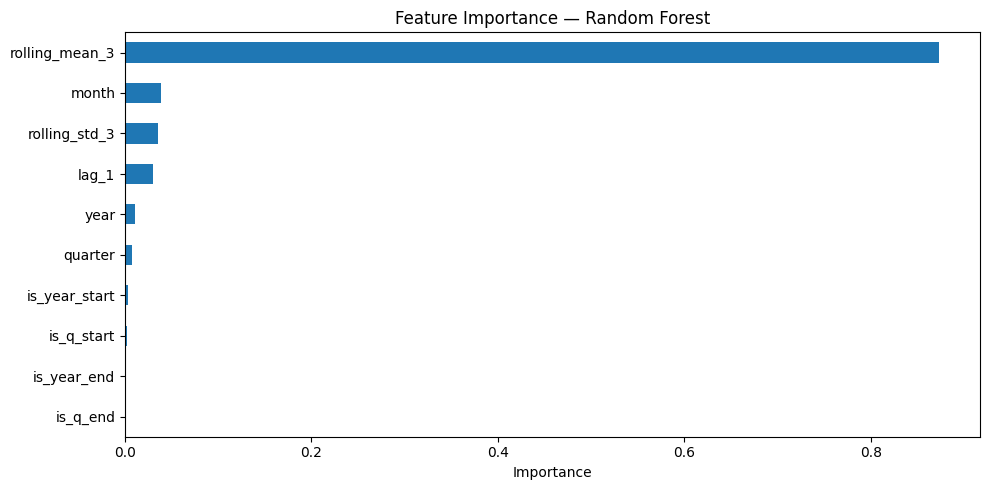

In [22]:
importances = model.feature_importances_
feat_importances = pd.Series(importances, index=features).sort_values(ascending=True)

feat_importances.plot(kind="barh", figsize=(10, 5))
plt.title("Feature Importance — Random Forest")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


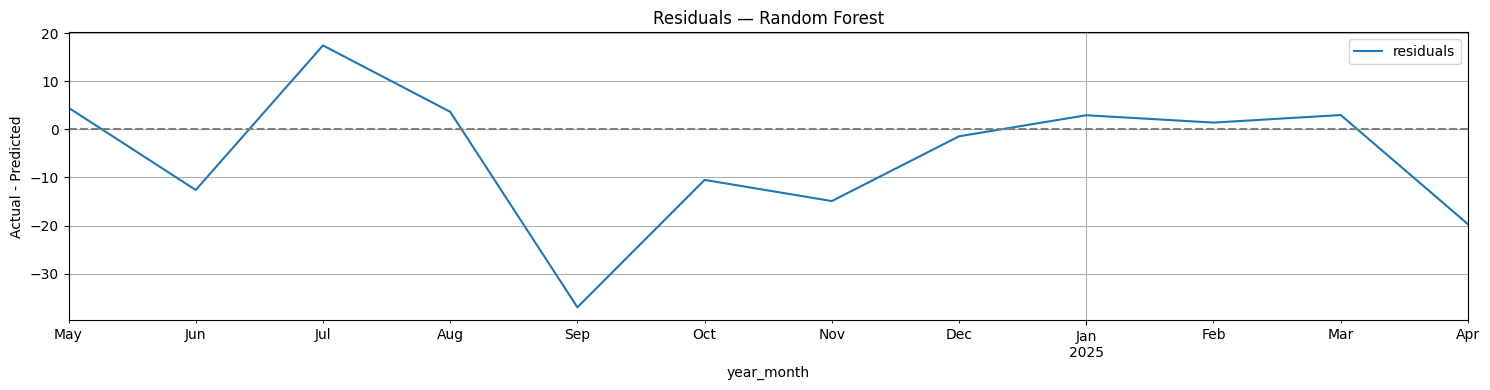

In [23]:
test["residuals"] = test["permit_count"] - test["prediction"]

test[["year_month", "residuals"]].plot(x="year_month", y="residuals", figsize=(15, 4))
plt.axhline(0, color="gray", linestyle="--")
plt.title("Residuals — Random Forest")
plt.ylabel("Actual - Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()


In [24]:
future = prophet_model.make_future_dataframe(periods=8, freq="M")
forecast = prophet_model.predict(future)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


In [25]:
forecast_2025 = forecast[forecast["ds"].dt.year == 2025]


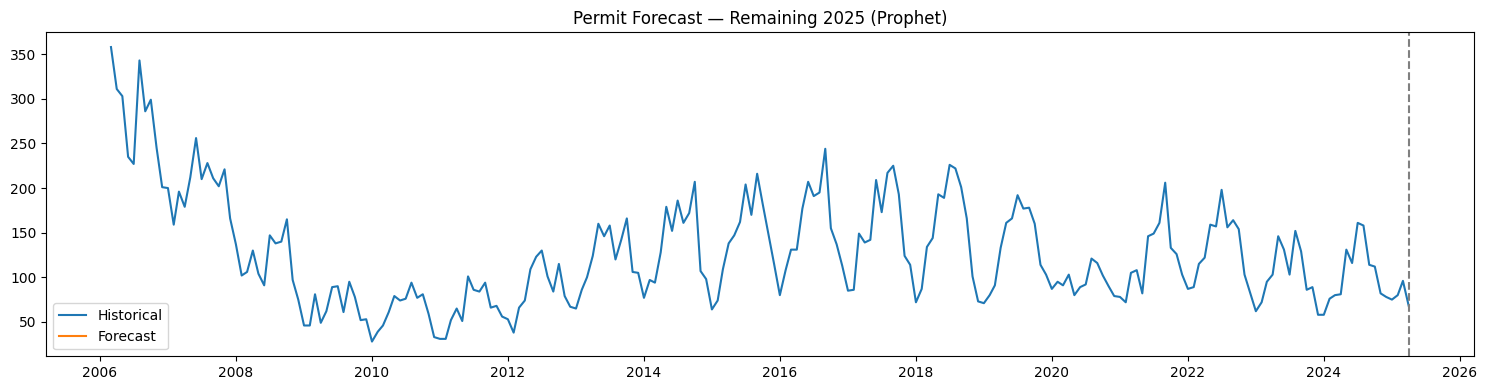

In [26]:
plt.figure(figsize=(15, 4))
plt.plot(df_prophet["ds"], df_prophet["y"], label="Historical")
plt.plot(forecast_2025["ds"], forecast_2025["yhat"], label="Forecast")
plt.axvline(pd.to_datetime("2025-04-01"), color="gray", linestyle="--")
plt.legend()
plt.title("Permit Forecast — Remaining 2025 (Prophet)")
plt.tight_layout()
plt.show()


In [27]:
# Extend forecast to end of 2025
future = prophet_model.make_future_dataframe(periods=8, freq="M")
forecast = prophet_model.predict(future)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


In [28]:
# Filter only future months (from April 2025 onward)
forecast_future = forecast[forecast["ds"] >= "2025-04-01"]


In [30]:
df_prophet["ds"].max()


Timestamp('2025-04-01 00:00:00')

In [31]:
from dateutil.relativedelta import relativedelta

# How many periods from last training date to Dec 2025
last_date = df_prophet["ds"].max()
target_end = pd.to_datetime("2025-12-01")
months_to_predict = (target_end.year - last_date.year) * 12 + (target_end.month - last_date.month)

future = prophet_model.make_future_dataframe(periods=months_to_predict, freq="M")
forecast = prophet_model.predict(future)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


In [35]:
from prophet import Prophet
import pandas as pd

# Refit Prophet (if needed)
prophet_model = Prophet()
prophet_model.fit(df_prophet)

# Generate explicit dates: May to Dec 2025
future_dates = pd.date_range(start="2025-05-01", end="2025-12-01", freq="MS")
future_df = pd.DataFrame({"ds": future_dates})

# Predict only on future
forecast_future = prophet_model.predict(future_df)


16:34:13 - cmdstanpy - INFO - Chain [1] start processing
16:34:13 - cmdstanpy - INFO - Chain [1] done processing


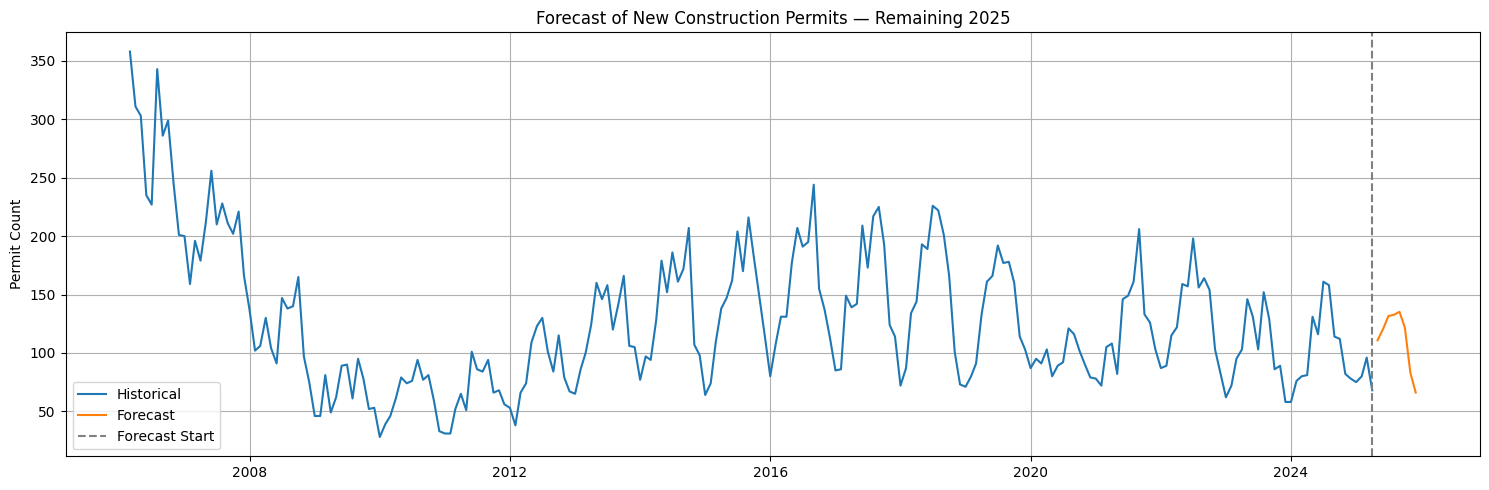

In [36]:
plt.figure(figsize=(15, 5))
plt.plot(df_prophet["ds"], df_prophet["y"], label="Historical")
plt.plot(forecast_future["ds"], forecast_future["yhat"], label="Forecast")
plt.axvline(pd.to_datetime("2025-04-01"), color="gray", linestyle="--", label="Forecast Start")
plt.legend()
plt.title("Forecast of New Construction Permits — Remaining 2025")
plt.ylabel("Permit Count")
plt.grid(True)
plt.tight_layout()
plt.show()
